<h1>Importowanie wymaganych bibliotek</h1>

In [17]:
import pandas as pd
import spotler.api.model_data.model_data_lib as modlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import top_k_accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import EditedNearestNeighbours
import matplotlib.ticker as plticker
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

In [18]:
# %load_ext pycodestyle_magic

In [19]:
%pycodestyle_off

UsageError: Line magic function `%pycodestyle_off` not found.


<h1>Wczytanie danych</h1>

<h3>Ustawienie ścieżek do plików z danymi</h3>

In [20]:
track_genres_query = modlib.TRACK_GENRE_SQL_QUERY
track_simple_genres_query = modlib.TRACK_SIMPLE_GENRE_SQL_QUERY

db_path = "spotler/db.sqlite3"
csv_name = "track_genres.csv"
csv_simple_genre_name = "track_simple_genres.csv"

<h3>Tworzenie CSV na podstawie kwerendy</h3>

In [21]:
modlib.create_csv_from_query(db_path, csv_name, track_genres_query, "\t")

['track_id', 'name', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'loudness', 'liveness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence', 'genre_name']


['track_id',
 'name',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'key',
 'loudness',
 'liveness',
 'mode',
 'speechiness',
 'tempo',
 'time_signature',
 'valence',
 'genre_name']

<h3> Wczytanie pliku csv</h3>

In [22]:
df = pd.read_csv(csv_name, sep="[\t]")

/tmp/ipykernel_6539/1184186776.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(csv_name, sep="[\t]")


In [23]:
df.head()

,track_id,name,acousticness,danceability,energy,instrumentalness,key,loudness,liveness,mode,speechiness,tempo,time_signature,valence,genre_name
0,1Qrg8KqiBpW07V7PNxwwwL,Kill Bill,0.0521,0.644,0.735,0.144,8,-5.747,0.161,1,0.0391,88.980,4,0.418,pop
1,1Qrg8KqiBpW07V7PNxwwwL,Kill Bill,0.0521,0.644,0.735,0.144,8,-5.747,0.161,1,0.0391,88.980,4,0.418,r&b
2,1Qrg8KqiBpW07V7PNxwwwL,Kill Bill,0.0521,0.644,0.735,0.144,8,-5.747,0.161,1,0.0391,88.980,4,0.418,rap
3,7ro0hRteUMfnOioTFI5TG1,WHERE SHE GOES,0.1430,0.652,0.800,0.629,9,-4.019,0.112,0,0.0614,143.978,4,0.234,reggaeton
4,7ro0hRteUMfnOioTFI5TG1,WHERE SHE GOES,0.1430,0.652,0.800,0.629,9,-4.019,0.112,0,0.0614,143.978,4,0.234,trap latino


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148506 entries, 0 to 148505
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          148506 non-null  object 
 1   name              148506 non-null  object 
 2   acousticness      148506 non-null  float64
 3   danceability      148506 non-null  float64
 4   energy            148506 non-null  float64
 5   instrumentalness  148506 non-null  float64
 6   key               148506 non-null  int64  
 7   loudness          148506 non-null  float64
 8   liveness          148506 non-null  float64
 9   mode              148506 non-null  int64  
 10  speechiness       148506 non-null  float64
 11  tempo             148506 non-null  float64
 12  time_signature    148506 non-null  int64  
 13  valence           148506 non-null  float64
 14  genre_name        148506 non-null  object 
dtypes: float64(9), int64(3), object(3)
memory usage: 17.0+ MB


<h1>Wstępna analiza danych</h1>

<h3>Badanie częstotliwości wszystkich gatunków</h3>

In [25]:
genres_freq = df["genre_name"].value_counts()
genres_freq = pd.DataFrame({"genres_number": genres_freq.index, "genres_appear": genres_freq.values})[
    "genres_appear"].value_counts()

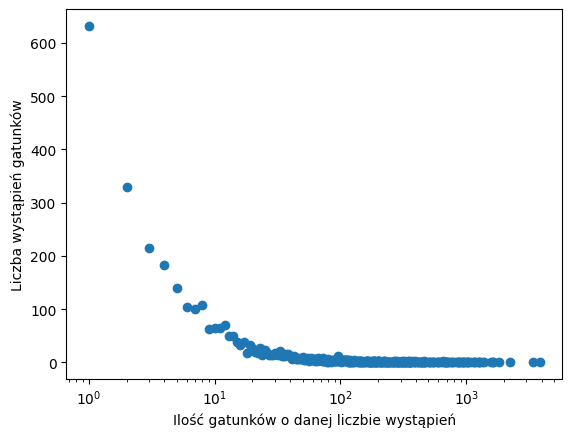

In [26]:
fig, ax = plt.subplots()
ax.scatter(genres_freq.index, genres_freq.values)
plt.xlabel("Ilość gatunków o danej liczbie wystąpień")
plt.ylabel("Liczba wystąpień gatunków")
plt.xscale("log")

plt.show()

<h3>Ograniczenie gatunków na podstawie ich popularności i analizy leksykalnej</h3>

In [27]:
all_columns =modlib.create_csv_from_query(
    db_path, csv_simple_genre_name, track_simple_genres_query, "\t")

['track_id', 'name', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'loudness', 'liveness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence', 'simplyfied_name']


In [28]:
df = pd.read_csv(csv_simple_genre_name, sep="[\t]")

/tmp/ipykernel_6539/2989146857.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(csv_simple_genre_name, sep="[\t]")


<h3>Liczba utworów o danym gatunku</h3>

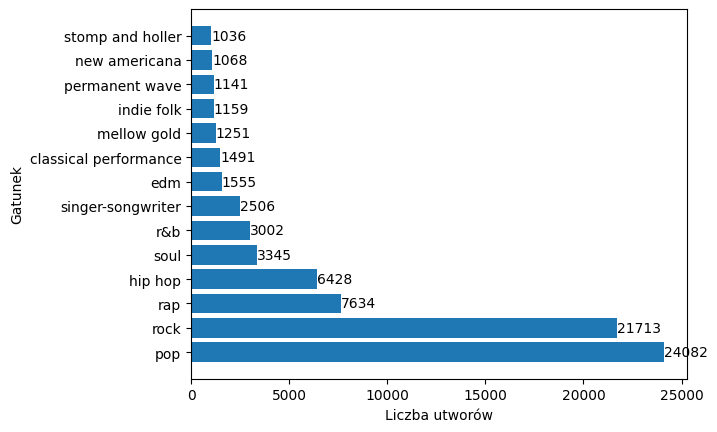

In [29]:
simplified_genre_count = (df["simplyfied_name"].value_counts())
fig, ax = plt.subplots()

bars = ax.barh(simplified_genre_count.index, simplified_genre_count.values)
ax.bar_label(bars)
ax.set_xlabel("Liczba utworów")
ax.set_ylabel("Gatunek")

plt.show()

<h3>Badanie procentowego udziału gatunków</h3>

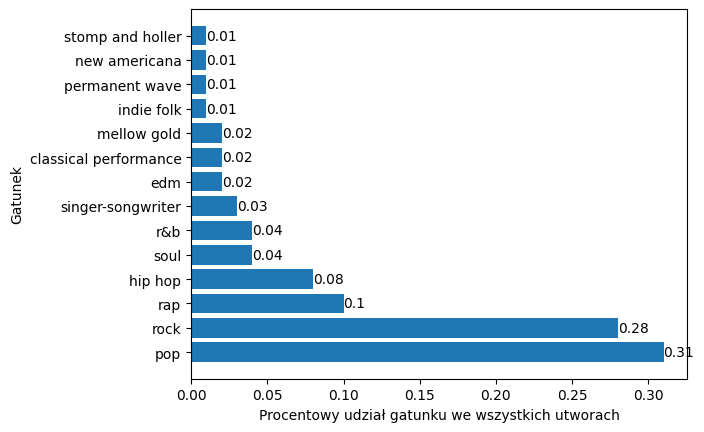

In [30]:
sum = simplified_genre_count.values.sum()
fig, ax = plt.subplots()

bars = ax.barh(
    simplified_genre_count.index,
    [round(amount/sum, 2) for amount in simplified_genre_count.values])

ax.bar_label(bars)
ax.set_xlabel("Procentowy udział gatunku we wszystkich utworach")
ax.set_ylabel("Gatunek")

plt.show()

<h1>Tworzenie zbalansowanego setu</h1>

In [31]:
X = df.iloc[:, 2:14].values
y = df.iloc[:, 14].values
rus = EditedNearestNeighbours()
X_rus, y_rus = rus.fit_resample(X, y)
new_df_list = [np.concatenate([row_data, [row_class]]) for row_data,row_class in zip(X_rus,y_rus)]
balanced_df = pd.DataFrame( new_df_list,
               columns=all_columns[2:])

balanced_df.head()

,acousticness,danceability,energy,instrumentalness,key,loudness,liveness,mode,speechiness,tempo,time_signature,valence,simplyfied_name
0,0.95,0.272,0.153,0.892,10.0,-20.058,0.312,1.0,0.0364,101.712,4.0,0.471,classical performance
1,0.95,0.272,0.153,0.892,10.0,-20.058,0.312,1.0,0.0364,101.712,4.0,0.471,classical performance
2,0.905,0.117,0.0539,0.849,11.0,-20.521,0.102,0.0,0.04,79.136,4.0,0.035,classical performance
3,0.964,0.119,0.031,0.165,2.0,-31.179,0.111,1.0,0.0483,88.858,4.0,0.0388,classical performance
4,0.964,0.119,0.031,0.165,2.0,-31.179,0.111,1.0,0.0483,88.858,4.0,0.0388,classical performance


In [32]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18373 entries, 0 to 18372
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   acousticness      18373 non-null  object
 1   danceability      18373 non-null  object
 2   energy            18373 non-null  object
 3   instrumentalness  18373 non-null  object
 4   key               18373 non-null  object
 5   loudness          18373 non-null  object
 6   liveness          18373 non-null  object
 7   mode              18373 non-null  object
 8   speechiness       18373 non-null  object
 9   tempo             18373 non-null  object
 10  time_signature    18373 non-null  object
 11  valence           18373 non-null  object
 12  simplyfied_name   18373 non-null  object
dtypes: object(13)
memory usage: 1.8+ MB


<h3>Badanie liczności liczności gatunków ze zbalansowanego setu</h3>

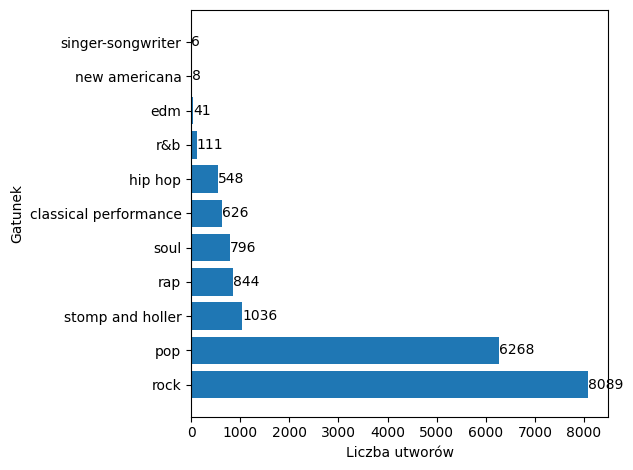

In [33]:
simplified_genre_count = (balanced_df["simplyfied_name"].value_counts())
fig, ax = plt.subplots()
bars = ax.barh(y=simplified_genre_count.index, width=simplified_genre_count.values)
ax.bar_label(bars)
ax.set_xlabel("Liczba utworów")
ax.set_ylabel("Gatunek")
plt.tight_layout()

plt.show()

<h1>Badanie rozkładu prawdopodobieństwa cech ilościowych</h1>


In [34]:
def chart_value_count(dataframe, index):
    if index in dataframe:
        counts = dataframe[index].value_counts()
        return counts.index, counts.values


def create_multiple_frequency_charts(
    df,
    index_keys,
    axis,
    number_of_columns
):

    for index, index_key in enumerate(index_keys):
        row_number = int(index/number_of_columns)
        data_count = chart_value_count(df, index_key)

        current_axis = axis[
            row_number,
            index-row_number*number_of_columns
        ]

        current_axis.scatter(data_count[0], data_count[1], s=0.5)
        current_axis.set_title(index_key)
        current_axis.set_xlabel("value")
        current_axis.set_ylabel("frequency")

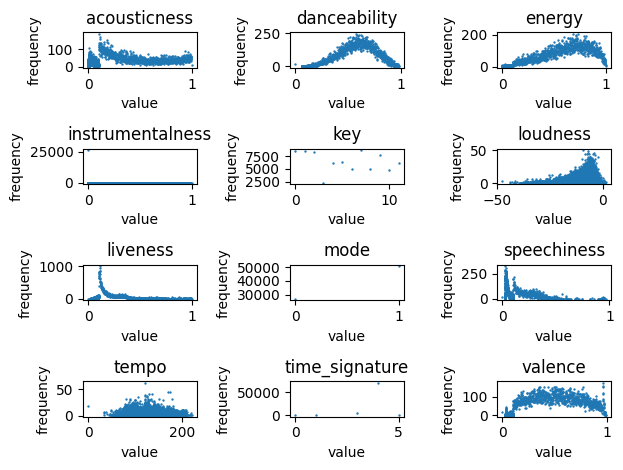

In [35]:
figure, axis = plt.subplots(4, 3)
column_names = [
    'acousticness', 'danceability', 'energy',
    'instrumentalness', 'key', 'loudness',
    'liveness', 'mode', 'speechiness',
    'tempo', 'time_signature', 'valence'
]

create_multiple_frequency_charts(df, column_names, axis, 3)

plt.tight_layout()
plt.show()

<h3>Badanie liczby gatunków utworu</h3>

In [36]:
genres_per_track = balanced_df.groupby(column_names).value_counts()
genres_per_track = pd.DataFrame({"genres_of_track": genres_per_track.values})["genres_of_track"].value_counts()

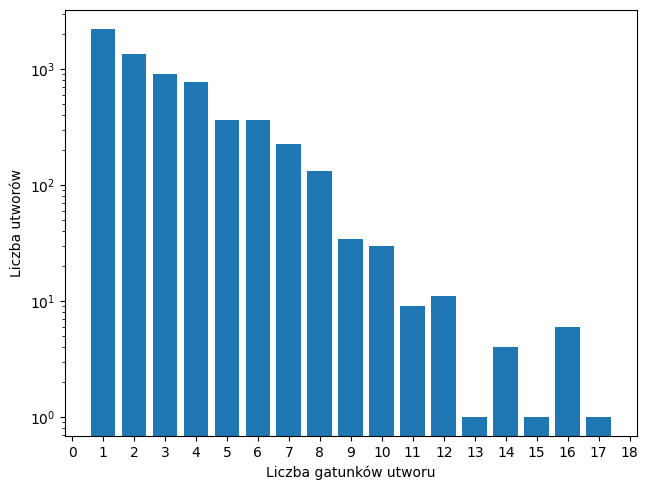

In [37]:
fig, ax = plt.subplots()
ax.bar(x=genres_per_track.index, height=genres_per_track.values)
loc = plticker.MultipleLocator(base=1.0)
ax.xaxis.set_major_locator(loc) 
ax.set_yscale("log")
plt.tight_layout()
ax.set_xlabel("Liczba gatunków utworu")
ax.set_ylabel("Liczba utworów")
plt.show()


<h1>Macierz korelacji</h1>

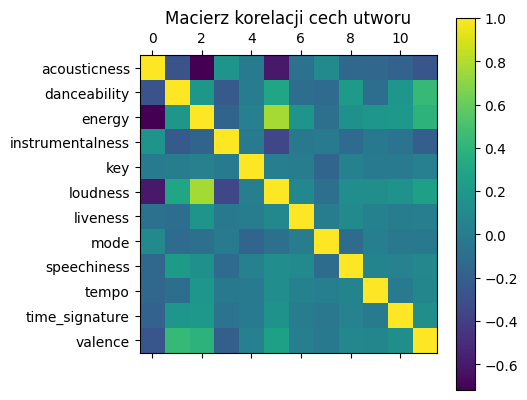

In [38]:
corr = df[column_names].corr()
plt.matshow(corr)
plt.title("Macierz korelacji cech utworu")
plt.colorbar()
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

<h1>Korelacje cech ilościowych</h1>

In [39]:
def create_all_correlation_charts_for_attribute(attribute_to_compare, all_atributes,):
    number_of_columns = 3
    integer_attributes = ["mode", "key"]
    fig, ax = plt.subplots(4, number_of_columns)
    for index, attribute in enumerate(all_atributes):
        row_number = int(index/number_of_columns)
        current_axis = ax[
            row_number,
            index-row_number*number_of_columns
        ]

        current_axis.scatter(df[attribute_to_compare], df[attribute], s=0.0001)

        # current_axis.scatter(df[attribute_to_compare], df[attribute], s=0.001)
        current_axis.set_xlabel(attribute_to_compare)
        current_axis.set_ylabel(attribute)
    plt.tight_layout()
    plt.show()

<h3>Badanie korelacji akustyczności</h3>

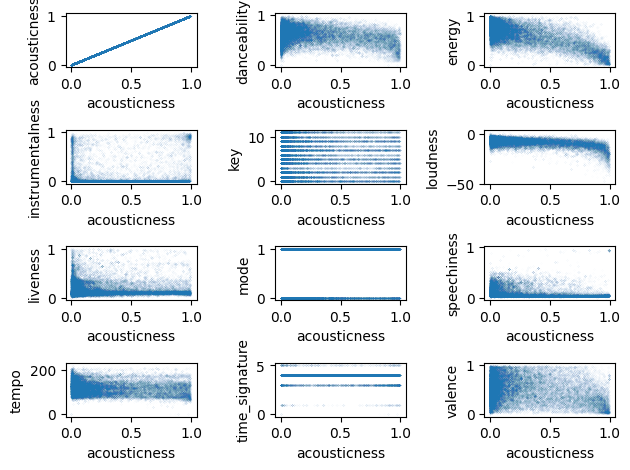

In [40]:
create_all_correlation_charts_for_attribute("acousticness", column_names)

<h3>Badanie korelacji energi</h3>

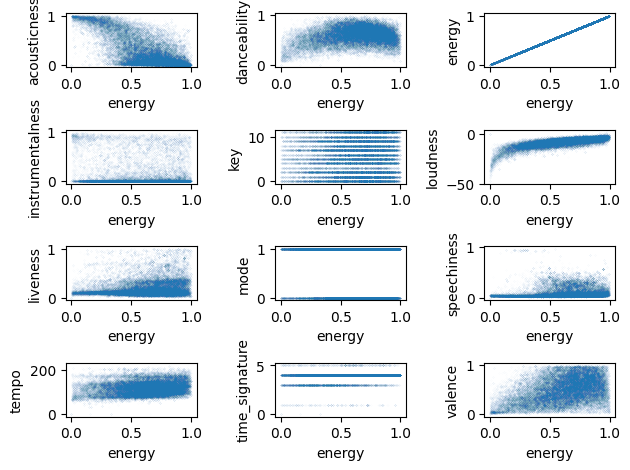

In [41]:
create_all_correlation_charts_for_attribute("energy", column_names)

<h3>Badanie korelacji instrumentalności</h3>

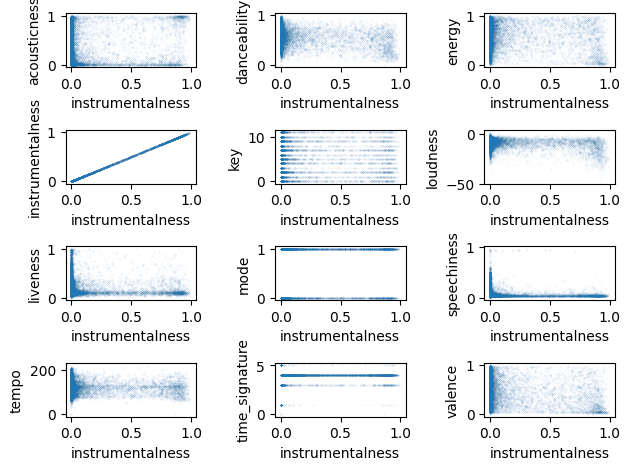

In [42]:
create_all_correlation_charts_for_attribute("instrumentalness", column_names)

<h3>Badanie korelacji klucza</h3>

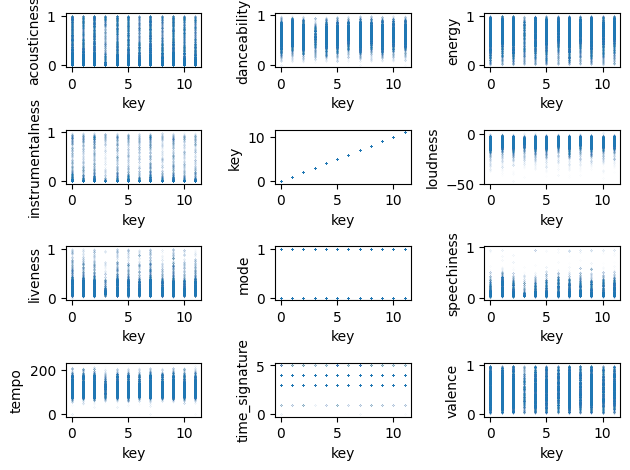

In [43]:
create_all_correlation_charts_for_attribute("key", column_names)

<h3>Badanie korelacji głośności</h3>

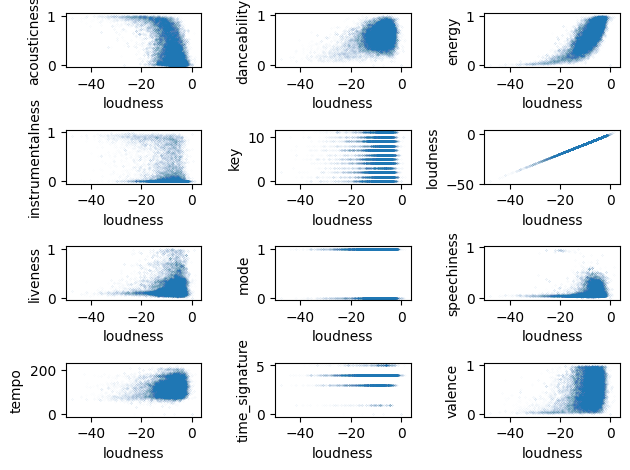

In [44]:
create_all_correlation_charts_for_attribute("loudness", column_names)

<h3>Badanie korelacji żywotności</h3>

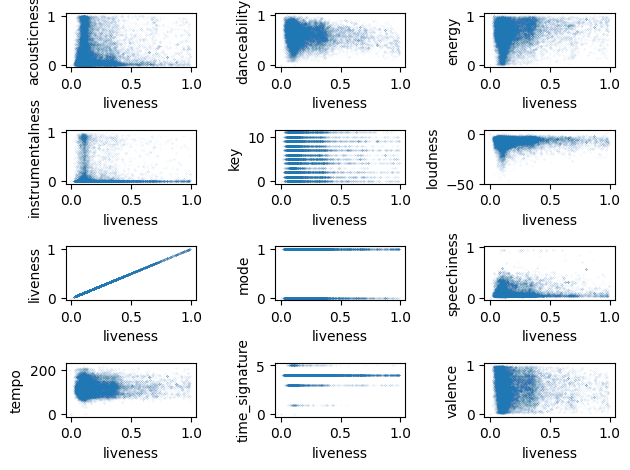

In [45]:
create_all_correlation_charts_for_attribute("liveness", column_names)

<h3>Badanie korelacji modalności</h3>

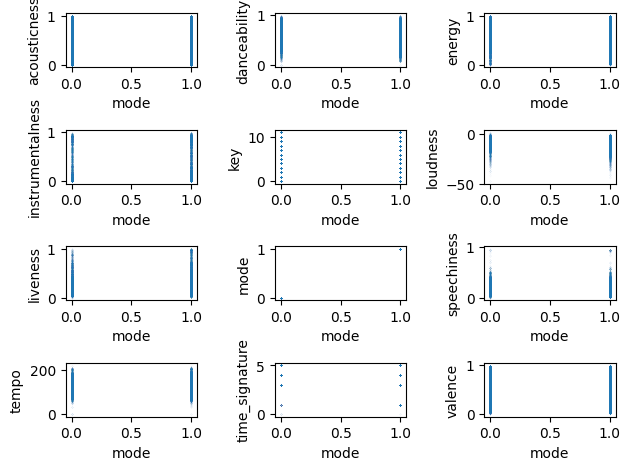

In [46]:
create_all_correlation_charts_for_attribute("mode", column_names)

<h3>Badanie korelacji współczynnika obecności słów</h3>

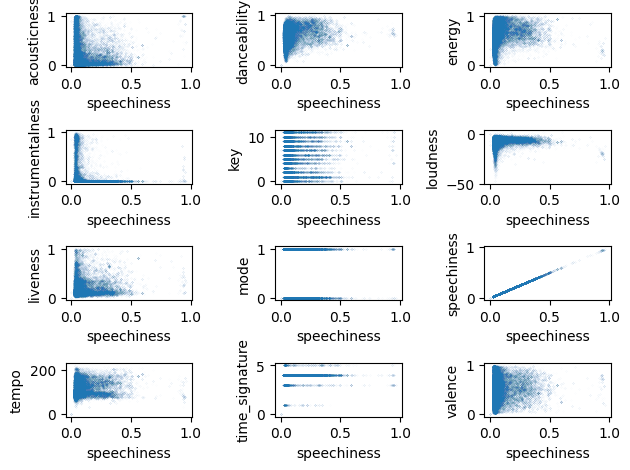

In [47]:
create_all_correlation_charts_for_attribute("speechiness", column_names)

<h3>Badanie korelacji tempa</h3>

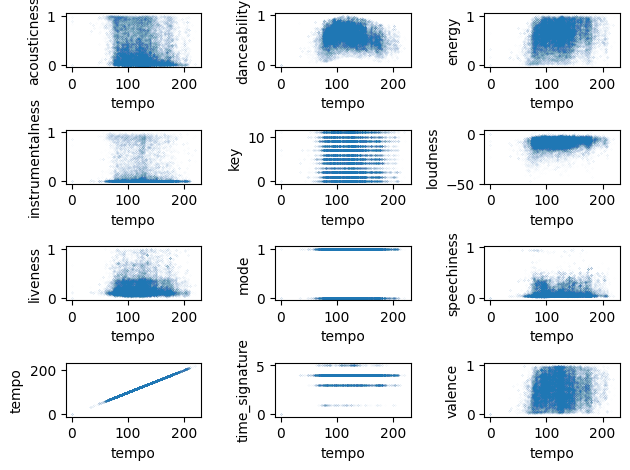

In [48]:
create_all_correlation_charts_for_attribute("tempo", column_names)

<h3>Badanie korelacji sygnatury czasowej</h3>

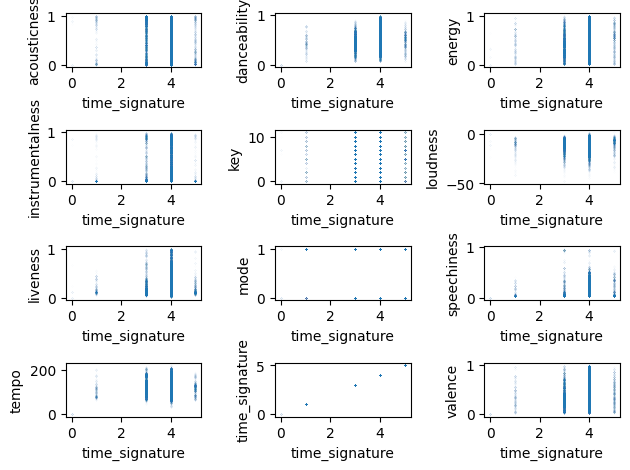

In [49]:
create_all_correlation_charts_for_attribute("time_signature", column_names)

<h3>Badanie korelacji pozytywności</h3>

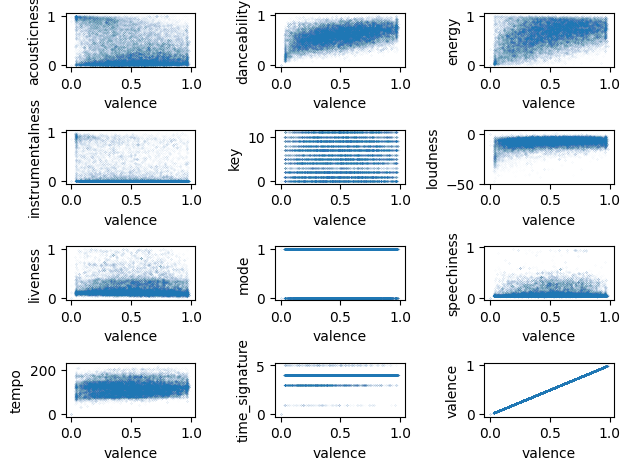

In [50]:
create_all_correlation_charts_for_attribute("valence", column_names)

<h1>Spliting dataset to training set and testing set<h1>

In [51]:
X_train, X_test,  Y_train, Y_test = train_test_split(df[column_names].values,
                                                     df["simplyfied_name"].values,
                                                     test_size=0.2,
                                                     random_state=42,
                                                     stratify=df["simplyfied_name"].values)

In [52]:
X_balanced_train, X_balanced_test,  Y_balanced_train, Y_balanced_test = train_test_split(
                                                     balanced_df[column_names].values,
                                                     balanced_df["simplyfied_name"].values,
                                                     test_size=0.2,
                                                     random_state=42,
                                                     stratify=balanced_df["simplyfied_name"].values)

<h1>Trenowanie modeli i badanie ich efektywności</h1>

In [53]:
def run_top_k_accuracy_score_of_model(model, X_test, Y_test, k):
    Y_score = [model.predict_proba([x])[0] for x in X_test]
    return top_k_accuracy_score(Y_test, Y_score, k=k)


def draw_chart_of_k_accuracy_score_of_model(model, X_test, Y_test):
    _, ax = plt.subplots()
    class_range = range(1, len(model.classes_))
    ax.scatter(class_range, [run_top_k_accuracy_score_of_model(
        model, X_test, Y_test, k=k) for k in class_range])
    ax.set_xticks(class_range)
    ax.set_xlabel("Liczba akceptowanych klasyfikatorów")
    ax.set_ylabel("Jakość modelu")

    plt.show()

In [54]:
def get_top_k_accuracy_of_model(model, X_test, Y_test):
    class_range = range(1, len(model.classes_))
    return [run_top_k_accuracy_score_of_model(
        model, X_test, Y_test, k=k) for k in class_range]

def draw_chart_of_k_accuracy_score_of_models(models, X_test_sets, Y_test_sets, model_labels):
    _,ax = plt.subplots()
    
    for model, X_test, Y_test, label in zip(models,X_test_sets,Y_test_sets, model_labels):
        model_scores = get_top_k_accuracy_of_model(model, X_test, Y_test)
        model_class_range = range(1, len(model.classes_))
        ax.scatter(model_class_range, model_scores, label=label)

        
        
    ax.set_xlabel("Liczba akceptowanych klasyfikatorów")
    ax.set_ylabel("Jakość modelu")
    loc = plticker.MultipleLocator(base=1.0)
    ax.xaxis.set_major_locator(loc) 
    plt.legend(loc='lower right')
    plt.show()



In [55]:
def get_predicted_genres(classes, result_prob):

    result = [{"genre": prob_class, "probability": prob_value}
              for prob_class, prob_value in zip(classes, result_prob[0])]
    result.sort(key=lambda el: el["probability"], reverse=True)
    return result


def get_predicted_genre_proba(classes, classname, result_prob):
    predicted_map = get_predicted_genres(classes, result_prob)
    return list(filter(lambda class_prob: class_prob["genre"] == classname, predicted_map))[0]["probability"]

In [56]:
def put_label_on_a_bar(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2,
                1.05*height,round(height,2),
                ha='center', va='bottom')

def draw_balanced_to_imbalanced_set_score_comparison(model_name,
                                                     imbalanced_model,
                                                     balanced_model,
                                                     X_balanced_test,
                                                     Y_balanced_test,
                                                     X_imbalanced_test,
                                                     Y_imbalanced_test,
                                                     ):
    
    imbalanced_model_score_on_imbalanced_set = imbalanced_model.score(X_imbalanced_test, Y_imbalanced_test)
    imbalanced_model_score_on_balanced_set = imbalanced_model.score(X_balanced_test, Y_balanced_test)
    balanced_model_score_on_imbalanced_set = balanced_model.score(X_imbalanced_test, Y_imbalanced_test)
    balanced_model_score_on_balanced_set = balanced_model.score(X_balanced_test, Y_balanced_test)
    
    width=0.35

    _,ax = plt.subplots()
    
    balanced_model_bar = ax.bar(["Balanced set", "Imbalanced set"],
           [balanced_model_score_on_balanced_set,
           balanced_model_score_on_imbalanced_set],
           -width,
           label=("Balanced "+model_name),
           align="edge")
    
    imbalanced_model_bar = ax.bar(["Balanced set", "Imbalanced set"],
           [imbalanced_model_score_on_balanced_set,
           imbalanced_model_score_on_imbalanced_set],
           +width,
           label=("Imbalanced "+model_name),
           align="edge")
    
    put_label_on_a_bar(balanced_model_bar)
    put_label_on_a_bar(imbalanced_model_bar)

    ax.set_ylabel("Średni wynik modelu")
    ax.set_xlabel("Rodzaj setu")
    ax.set_ylim(bottom=0,top=1)
    plt.legend(loc="upper right")
    
    plt.show()

<h1>LDA - Linear Dyscriminant Analysis</h1>

In [57]:
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())
lda.fit_transform(X_train, Y_train)

array([[-1.1677691 , -0.32326033, -1.40532135, ...,  0.15386996,
         0.72647681, -0.20053148],
       [ 1.53136191, -0.22961347,  0.24701534, ...,  0.22212367,
        -0.15913696, -0.16709539],
       [-2.37347713, -1.66963803, -0.95527575, ...,  0.34431633,
        -0.26809637,  2.2696828 ],
       ...,
       [ 0.3129094 ,  0.17938053, -0.56520991, ...,  0.32808893,
         2.01275289,  1.97466628],
       [-1.22538267,  0.12207078, -0.59330415, ..., -1.33787042,
         0.28504505, -0.34150137],
       [-0.76178266, -0.5961052 , -1.15103869, ..., -0.91857271,
         0.8001339 , -0.29035697]])

In [58]:
balanced_lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())
balanced_lda.fit_transform(X_balanced_train, Y_balanced_train)

array([[-1.65123788, -0.9146107 ,  2.07002457, ...,  0.33449894,
        -0.86469725, -0.32756043],
       [-0.52347969,  0.71056166,  0.66875159, ...,  0.68451399,
        -0.15751323, -0.88325126],
       [-2.9646305 , -3.10594558,  1.02036608, ...,  1.21094259,
        -1.79827872,  1.32511561],
       ...,
       [ 0.99809891,  0.28927891,  1.76293545, ...,  1.56316242,
         1.99707801,  1.55436757],
       [-1.35168691, -1.14837553,  0.04134801, ..., -0.37952876,
         1.17643403,  0.83682239],
       [ 0.99289526, -0.48685274, -2.10792568, ...,  0.26943599,
        -0.70069836,  0.02790829]])

In [59]:
lda.score(X_test, Y_test)

0.4478460246722211

In [60]:
balanced_lda.score(X_test, Y_test)

0.4375766970225409

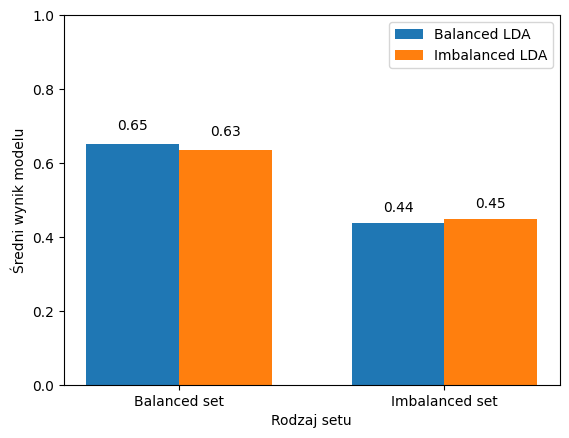

In [61]:
draw_balanced_to_imbalanced_set_score_comparison("LDA",lda, balanced_lda,X_balanced_test, Y_balanced_test, X_test, Y_test)

In [62]:
run_top_k_accuracy_score_of_model(lda, X_test, Y_test, 2)

0.6813279080281599

In [63]:
run_top_k_accuracy_score_of_model(balanced_lda, X_balanced_test, Y_balanced_test, 2)

0.8574149659863946

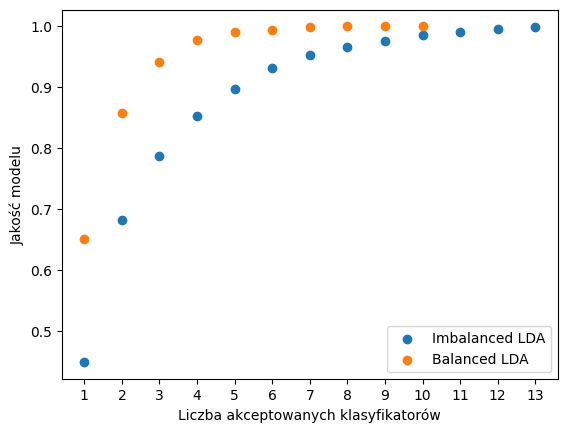

In [46]:
draw_chart_of_k_accuracy_score_of_models(
    [lda, balanced_lda], [X_test, X_balanced_test], [Y_test, Y_balanced_test],
    ["Imbalanced LDA", "Balanced LDA"])

<h1>SVC</h1>


In [137]:
svc = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
balanced_svc = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))

In [ ]:
svc.fit(X_train, Y_train)

In [ ]:
balanced_svc.fit(X_balanced_train, Y_balanced_train)

In [ ]:
svc.score(X_test, Y_test)

In [149]:
balanced_svc.score(X_balanced_test, Y_balanced_test)

0.7235374149659864

In [ ]:
draw_chart_of_k_accuracy_score_of_models(
    [svc, balanced_svc], [X_test, X_balanced_test], [Y_test, Y_balanced_test],
    ["Imbalanced SVC", "Balanced SVC"])

<h1>Random Forest Classifier</h1>

In [64]:
regressor = RandomForestClassifier()
balanced_regressor = RandomForestClassifier()
# grid_search n-estimators, n-features


In [65]:
regressor.fit(X_train, Y_train)

RandomForestClassifier()

In [66]:
balanced_regressor.fit(X_balanced_train, Y_balanced_train)

RandomForestClassifier()

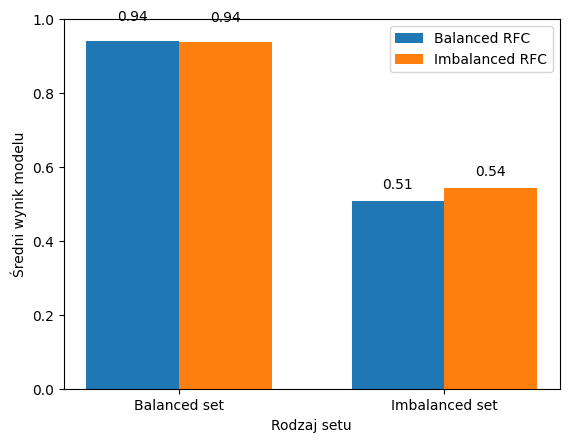

In [69]:
draw_balanced_to_imbalanced_set_score_comparison("RFC",
                                                 regressor,
                                                 balanced_regressor,
                                                 X_balanced_test, 
                                                 Y_balanced_test, 
                                                 X_test, 
                                                 Y_test)

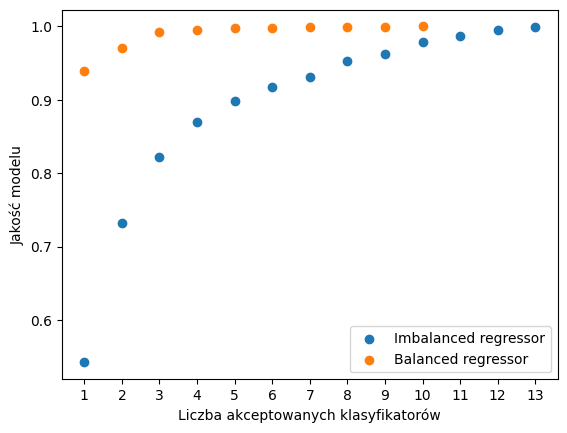

In [101]:
draw_chart_of_k_accuracy_score_of_models(
    [regressor, balanced_regressor], [X_test, X_balanced_test], [Y_test, Y_balanced_test],
    ["Imbalanced regressor", "Balanced regressor"])

In [48]:
run_top_k_accuracy_score_of_model(svc,X_test, Y_test, 2)

0.9058503401360545

In [63]:
run_top_k_accuracy_score_of_model(lda, X_test, Y_test, 2)

0.6813279080281599

In [68]:
run_top_k_accuracy_score_of_model(regressor, X_test, Y_test, 3)

0.8232900600658787

<h1>Cross validation of models</h1>

<h3>LDA</h3>

In [56]:
lda_cross_val_scores = cross_val_score(lda,
                                       df[column_names], 
                                       df["simplyfied_name"],
                                       cv=5)
lda_cross_val_scores

array([0.44287283, 0.44703527, 0.45820953, 0.43934892, 0.42242604])

In [132]:
balanced_lda_cross_val_scores = cross_val_score(balanced_lda,
                                                balanced_df[column_names],
                                                balanced_df["simplyfied_name"],
                                                cv=5)
balanced_lda_cross_val_scores

array([0.62095238, 0.67537415, 0.64517007, 0.64126293, 0.60560697])

<h3>SVC</h3>

In [53]:
svc_scores = cross_val_score(svc, 
                             df[column_names], 
                             df["simplyfied_name"], 
                             cv=5)
svc_scores

array([0.62938776, 0.69877551, 0.66829932, 0.64235166, 0.64697877])

In [ ]:
balanced_svc_scores = cross_val_score(svc, 
                                      balanced_df[column_names], 
                                      balanced_df["simplyfied_name"], 
                                      cv=5)
balanced_svc_scores

<h3>Random Regression Forest</h3>

In [102]:
regressor_cross_val_scores = cross_val_score(regressor, 
                                             df[column_names],
                                             df["simplyfied_name"], 
                                             cv=5)
regressor_cross_val_scores

array([0.4033456 , 0.34827542, 0.36707144, 0.3928433 , 0.43282522])

In [103]:
balanced_regressor_cross_val_scores = cross_val_score(balanced_regressor, 
                                                      balanced_df[column_names], 
                                                      balanced_df["simplyfied_name"], 
                                                      cv=5)
balanced_regressor_cross_val_scores

array([0.68843537, 0.71945578, 0.70231293, 0.72346217, 0.6927055 ])